Import required packages

In [1]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
from geopy import distance
import folium
import requests
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Import Foursquare credentials from json file created to preserve secrecy and store in global variables CLIENT_ID and CLIENT_SECRET

In [2]:
import json
globals().update(json.loads(open("foursquareCredentials.json", "r") .read()))
VERSION = '20181124' # Foursquare API version

## Input the variables that define the problem
Get longitude and latitude of location where we want to open a new business

In [3]:
geolocator = Nominatim(user_agent="specify_your_app_name_here")
#location = geolocator.geocode("Budapest Hungary")
location = geolocator.geocode("Toronto")
#location = geolocator.geocode("canterbury uk")
lat = location.latitude
long = location.longitude
location

Location(Toronto, Ontario, Canada, (43.653963, -79.387207, 0.0))

Populate variables containing the other parameters of the search problem:
* categoryId = foursquare categoryId of the venue we wish to open. A full list of categories can be found here: https://developer.foursquare.com/docs/resources/categories.
* radius = the maximum distance from the location within which we want to open the venue in km.
* tick = the level of accuracy in km which we want to return for the recommended locations. 

In [4]:
categoryId = '4bf58dd8d48988d16d941735' # Café
#categoryId = '4bf58dd8d48988d1ca941735' # Pizza
#categoryId = '4bf58dd8d48988d1cc941735' # Steakhouse
radius = 1
tick = 0.2

## Build grid of points within radius of location
Define function degreeLen which for a given lat and long returns the length of a degree of lat and long in km

In [5]:
def degreeLen(lat, long):
    """Returns the lengths of a single degree of latitude and longitude in km for a given latitude and longitude
    """
    # get length of 1 degree at current latidude and logitude
    latDegree = distance.distance((lat - 0.5, long), (lat + 0.5, long)).km
    longDegree = distance.distance((lat, long - 0.5), (lat, long + 0.5)).km
    return latDegree, longDegree


degreeLen(lat, long)

(111.1054893296284, 80.6703885005979)

Define function grid that returns the set of grid points within a circle around location.  Grid points are a distance tick apart.

In [6]:
def grid(lat, long, radius, tick):
    """Returns a set whose elements are a grid of points within a circle around a location
    :param lat: latitude of centre of grid
    :param long: longitude of centre of grid
    :param radius: radius of grid in km
    :param tick: distance between points in grid in km
    """
    # get length of 1 degree at current latidude and logitude
    latDegree, longDegree = degreeLen(lat, long)
    
    # get length of 1 tick in degrees
    latTick = tick / latDegree
    longTick = tick / longDegree
    
    # get coordinates of point which is one radius to the South and West of (lat, long)
    bottomLeft = (lat - radius / latDegree, long - radius / longDegree)
    
    # get tick points along axis
    gridLats = np.arange(2 * radius / tick + 1) * latTick + bottomLeft[0]
    gridLongs = np.arange(2 * radius / tick + 1) * longTick + bottomLeft[1]
    
    # create the set grid made up of points within radius of lat, long, disance tick apart 
    grid = {(lt, lg) for lt in gridLats for lg in gridLongs if distance.distance((lat, long), (lt, lg)).km <= radius}
    
    return grid

Check grid function is working using Folium

In [7]:
g = grid(lat, long, radius, tick)
print("Number of points in grid = " + str(len(g)))

# create map
map_grid = folium.Map(location=[lat, long], zoom_start=14)

# add grid points to map
for (lt, lg) in g:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=1).add_to(map_grid)
    
# add circle of radius radius around location
folium.features.Circle((lat, long), radius * 1000, weight = 1, color='black', fill_opacity=0.0).add_to(map_grid)

# show map
map_grid

Number of points in grid = 74


## Build function which pulls venue data from Foursquare
Define function for pulling list of nearby venues, with optional filter on category Id

In [8]:
# Define template url for the API request
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&intent=browse&ll={},{}&radius={}&categoryId={}'


def getNearbyVenues(lat, long, radius, categoryId = ''):
    
    # populate template url with the necessary values
    apiCall = url.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, long, radius, categoryId)
    
            
    # make the GET request
    venues = requests.get(apiCall).json()['response']['venues']
    
    # initialise venues list
    venues_list=[]
    
    # add venue details to list
    for v in venues:
        # some locations don't have a category, so we need to cope with this scenario
        if len(v['categories']) > 0:
            venues_list.append([v['id'], v['name'], v['location']['lat'], v['location']['lng'],
                                v['location']['distance'], v['categories'][0]['name']])
        else:
            venues_list.append([v['id'], v['name'], v['location']['lat'], v['location']['lng'],
                                v['location']['distance'], 'None'])
    
    return(venues_list)

Check function getNearbyVenues is working

In [9]:
getNearbyVenues(lat, long, tick * 1000, categoryId)

[['4f513029e4b07c3382c9fdb9',
  'Cafe Plenty',
  43.65457125894357,
  -79.38944976536852,
  192,
  'Café'],
 ['4b0d2ef1f964a520664423e3',
  'Avenue Café + Bistro',
  43.655117004427716,
  -79.38876401060952,
  179,
  'Sandwich Place'],
 ['5706b570498e618216dbfd32',
  "Uncle Tetsu's Japanese Angel Cafe",
  43.655001311444025,
  -79.38689900686445,
  118,
  'Café'],
 ['4b59d414f964a5208f9a28e3',
  "Java Joe's",
  43.655201241300766,
  -79.38633252158125,
  154,
  'Café'],
 ['51bd60fa498e5ce3f52c6016',
  'Prince Cafe',
  43.654916,
  -79.387351,
  106,
  'Café'],
 ['50b77ec7e4b08ecf5a78a68f',
  'Urbana Coffee Co.',
  43.65322456230742,
  -79.38874882569176,
  148,
  'Café'],
 ['58e716e5fa7ed04f61194722',
  'Café De Paris, Downtown Toronto',
  43.654872,
  -79.387429,
  102,
  'Café'],
 ['4bd8dd55cc5b95215c3af24f',
  'Bistro 438',
  43.6543883919314,
  -79.38845743028736,
  111,
  'Bistro'],
 ['50046391e4b025b2598516f3',
  'Coffee Antidote 9th Floor',
  43.654360144769974,
  -79.3886663553

## Build function to calculate density of venues within a specified radius of a location
Define function venueDensity which outputs a measure the density of a list of venues within a specific radius of a location.
The density measure has the property of being larger the more venues there are in the list and the closer they are.
So for each venue we subtract the distance of the venue from the location from the radius.
This measure is then summed up for all the venues

Worked example, radius = 200m, 2 venues, 1 distance 1m from the location, the other distance 199m:
* venue 1 density = 200 - 1 = 199
* venue 2 density = 200 - 199 = 1
* total density = 199 + 1 = 200

In [10]:
def venueDensity(venues, radius):
    distances = []
    [distances.append(radius - v[4]) for v in venues if v[4] < radius]
    return np.sum(np.asarray(distances))

In [11]:
venueDensity(getNearbyVenues(lat, long, tick * 1000, categoryId), tick * 1000)

565.0

In [12]:
# Check if density for empty list of venues = 0
venueDensity([], tick * 1000)

0.0

## Get venue density for each point on the grid around location

In [13]:
# Initialise list to hold densities
densities = []

# Initialise set to hold the venues in the category we wish to open
targetVenues = set()

# Initialise set to hold the ids of the target venues
ids = set()

# Get number of points in the grid
total = len(g)

# initialise a counter to 0
i = 0

# calculate Density of target venues around each point in the grid
for (lt, lg) in g:
    i+=1
    print("Getting venues for point " + str(i) + ' of ' + str(total))
    venues = getNearbyVenues(lt, lg, tick * 1000, categoryId)
    density = venueDensity(venues, tick * 1000)
    densities.append((lt, lg, density))
    for (v_id, name, vlt, vlg, dist, category) in venues:
        ids.add(v_id)
        targetVenues.add((v_id, name, vlt, vlg))

Getting venues for point 1 of 74
Getting venues for point 2 of 74
Getting venues for point 3 of 74
Getting venues for point 4 of 74
Getting venues for point 5 of 74
Getting venues for point 6 of 74
Getting venues for point 7 of 74
Getting venues for point 8 of 74
Getting venues for point 9 of 74
Getting venues for point 10 of 74
Getting venues for point 11 of 74
Getting venues for point 12 of 74
Getting venues for point 13 of 74
Getting venues for point 14 of 74
Getting venues for point 15 of 74
Getting venues for point 16 of 74
Getting venues for point 17 of 74
Getting venues for point 18 of 74
Getting venues for point 19 of 74
Getting venues for point 20 of 74
Getting venues for point 21 of 74
Getting venues for point 22 of 74
Getting venues for point 23 of 74
Getting venues for point 24 of 74
Getting venues for point 25 of 74
Getting venues for point 26 of 74
Getting venues for point 27 of 74
Getting venues for point 28 of 74
Getting venues for point 29 of 74
Getting venues for poin

Show target venues on map

In [14]:
print("Number of venues = " + str(len(targetVenues)))

# create map
m = folium.Map(location=[lat, long], zoom_start=14)

# add venues to map
for (v_id, name, vlt, vlg) in targetVenues:
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([vlt, vlg],
                        color='black',
                        radius=0.1,
                        popup=label,
                        fill=False).add_to(m)
    
# add circle of radius radius around location
folium.features.Circle((lat, long), radius * 1000, weight = 1, color='black', fill_opacity=0.0).add_to(m)

# show map  
m

Number of venues = 190


Convert densities into a DataFrame

In [15]:
densitiesDf = pd.DataFrame(densities)
densitiesDf.columns = ['Latitude', 'Longitude', 'Density']
densitiesDf.set_index(['Latitude', 'Longitude'], inplace=True)
densitiesDf.sort_index(inplace=True)
densitiesDf

Density
Latitude  Longitude          
43.644963 -79.387207    773.0
43.646763 -79.392165    382.0
          -79.389686    544.0
          -79.387207    473.0
          -79.384728    742.0
          -79.382249   1127.0
43.648563 -79.394645    545.0
          -79.392165    472.0
          -79.389686    623.0
          -79.387207    231.0
          -79.384728    706.0
          -79.382249   1043.0
          -79.379769   1425.0
43.650363 -79.397124    267.0
          -79.394645     82.0
          -79.392165    341.0
          -79.389686    550.0
          -79.387207    172.0
          -79.384728   1087.0
          -79.382249    884.0
          -79.379769    726.0
          -79.377290   1303.0
43.652163 -79.397124    524.0
          -79.394645     98.0
          -79.392165    295.0
          -79.389686    188.0
          -79.387207     29.0
          -79.384728    138.0
          -79.382249    766.0
          -79.379769    788.0
...                       ...
43.655763 -79.387207    645.0
          -79.384728    833.0
          -79.382249    698.0
          -79.379769    787.0
          -79.377290    390.0
43.657563 -79.397124    137.0
          -79.394645    137.0
          -79.392165     94.0
          -79.389686    389.0
          -79.387207    256.0
          -79.384728    843.0
          -79.382249    711.0
          -79.379769    808.0
          -79.377290    367.0
43.659363 -79.397124    207.0
          -79.394645    141.0
          -79.392165     65.0
          -79.389686    161.0
          -79.387207    345.0
          -79.384728    101.0
          -79.382249    384.0
          -79.379769    133.0
          -79.377290     35.0
43.661163 -79.394645      0.0
          -79.392165      0.0
          -79.389686     27.0
          -79.387207    625.0
          -79.384728    425.0
          -79.382249    431.0
          -79.379769    324.0

[74 rows x 1 columns]

Show heat map of densities

In [16]:
# calculate maximum density to use in heatmap opacity calulation
max_density = densitiesDf.max()

# Initialise map
m = folium.Map(location=[lat, long], zoom_start=14)

# get length of 1 degree at current latidude and logitude
ltDeg, lgDeg = degreeLen(lat, long)

# add rectangles around each point in grid to the map
for (lt, lg, density) in densities:
    # use opacity to show scale of density
    opacity = density / max_density
    
    # caluate corners of the rectangle around the current point in grid
    bottomLeft = [lt - tick / ltDeg / 2, lg - tick / lgDeg / 2]
    bottomRight = [lt - tick / ltDeg / 2, lg + tick / lgDeg / 2]
    topRight = [lt + tick / ltDeg / 2, lg + tick / lgDeg / 2]
    topLeft = [lt + tick / ltDeg / 2, lg - tick / lgDeg / 2]
    
    # define the rectangle bounds
    bounds = [bottomLeft, bottomRight, topRight, topLeft]
    
    # add rectangles to map
    folium.features.RectangleMarker(bounds, weight=0, fill_color='red', fill_opacity=float(opacity)).add_to(m) 

    
# add circle of radius radius around location   
folium.features.Circle((lat, long), radius * 1000, weight = 1, color='black', fill_opacity=0.0).add_to(m)

# add venues to map
for (v_id, name, vlt, vlg) in targetVenues:
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([vlt, vlg],
                        color='black',
                        radius=0.1,
                        popup=label,
                        fill=False).add_to(m)

# display heatmap
m

Review distribution of densities: want it to be approximately normal if we are to build a regression model to predict it

In [17]:
densitiesDf.describe()

,Density
count,74.000000
mean,457.202703
std,331.438251
min,0.000000
25%,163.750000
50%,387.500000
75%,704.000000
max,1425.000000


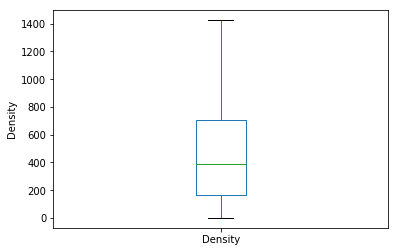

In [18]:
densitiesDf.plot(y='Density', kind='box')
plt.ylabel('Density')
plt.show()

In [19]:
densitiesDf['Log Density'] = np.log10(densitiesDf['Density'].values + 1)

In [20]:
densitiesDf.describe()

,Density,Log Density
count,74.000000,74.000000
mean,457.202703,2.462652
std,331.438251,0.573261
min,0.000000,0.000000
25%,163.750000,2.216648
50%,387.500000,2.589388
75%,704.000000,2.848184
max,1425.000000,3.154120


Density is skewed so take log

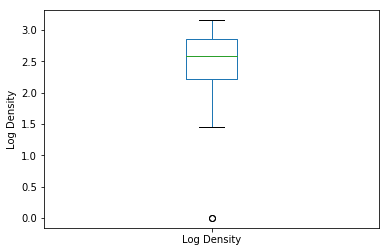

In [21]:
densitiesDf.plot(y='Log Density', kind='box')
plt.ylabel('Log Density')
plt.show()

## Get other venues around grid points
This data will be used to predict density of target venues

In [22]:
# initialise counter
i = 0

# initialise list for other venues
otherVenues = []

# get other venues around grid points
for (lt, lg) in g:
    
    i+=1
    print("Getting venues for point " + str(i) + ' of ' + str(total))
    
    # get venues around grid point from Foursquare
    venues = getNearbyVenues(lt, lg, tick * 1000)
    
    # add venues to list if not in target venues and have a category
    for (v_id, name, vlt, vlg, dist, category) in venues:
        if not (v_id in ids) and category != 'None' and dist < tick * 1000 :
            otherVenues.append((lt, lg, v_id, name, vlt, vlg, dist, category))

Getting venues for point 1 of 74
Getting venues for point 2 of 74
Getting venues for point 3 of 74
Getting venues for point 4 of 74
Getting venues for point 5 of 74
Getting venues for point 6 of 74
Getting venues for point 7 of 74
Getting venues for point 8 of 74
Getting venues for point 9 of 74
Getting venues for point 10 of 74
Getting venues for point 11 of 74
Getting venues for point 12 of 74
Getting venues for point 13 of 74
Getting venues for point 14 of 74
Getting venues for point 15 of 74
Getting venues for point 16 of 74
Getting venues for point 17 of 74
Getting venues for point 18 of 74
Getting venues for point 19 of 74
Getting venues for point 20 of 74
Getting venues for point 21 of 74
Getting venues for point 22 of 74
Getting venues for point 23 of 74
Getting venues for point 24 of 74
Getting venues for point 25 of 74
Getting venues for point 26 of 74
Getting venues for point 27 of 74
Getting venues for point 28 of 74
Getting venues for point 29 of 74
Getting venues for poin

Create other venues dataframe from list

In [23]:
otherVenuesDf = pd.DataFrame(otherVenues)
otherVenuesDf.columns = ['Latitude', 'Longitude', 'VenueID', 'Name', 'VenueLat', 'VenueLong', 'Distance', 'Category']
otherVenuesDf.set_index(['Latitude', 'Longitude'], inplace=True)
otherVenuesDf.sort_index(inplace=True)
otherVenuesDf

VenueID  \
Latitude  Longitude                              
43.644963 -79.387207  4adc66c6f964a520142c21e3   
          -79.387207  4d2ce8d1fd2e236a8ac8ebde   
          -79.387207  4abfc91df964a5202a9220e3   
          -79.387207  514e1855e4b06c69f0c37117   
          -79.387207  4d7abb325462b60c93e7c9d8   
          -79.387207  4c4f16ba51c2c9280be46a9f   
          -79.387207  51b78155498e8ae18eca84b4   
          -79.387207  4b6b7458f964a520d9092ce3   
          -79.387207  51310ee0e4b099a3944c0023   
          -79.387207  4b7aed4af964a52095462fe3   
          -79.387207  58bd69dae6160c18feb37cf6   
          -79.387207  4ad4c064f964a52066f820e3   
          -79.387207  59678d0ba9e40247a7d7ccc2   
          -79.387207  4ea5c1ce4fc6db90f2f75a45   
          -79.387207  5853e602a37d723fddfcd9b6   
          -79.387207  5556384e498eb5d19c86ddda   
          -79.387207  563cb7f3498e997b5d1d378a   
          -79.387207  4e035abb6284217c7f125e2e   
          -79.387207  4ba0c45cf964a5204c7c37e3   
          -79.387207  4ae0af55f964a5209f8121e3   
          -79.387207  514898c3e4b0f2687d7c083a   
          -79.387207  58d2f50f0b56562b96c4d8ae   
          -79.387207  4ca611628a65bfb7611a2c22   
          -79.387207  4f68dc51e4b04bea43fe4c28   
          -79.387207  4b6b7488f964a520e5092ce3   
          -79.387207  4d067e87a2685481cf17c2bd   
          -79.387207  5363af4e498e605b2bfa54ce   
          -79.387207  4d274acdb818a35dc9378a8a   
43.646763 -79.392165  4ad4c05bf964a520aef520e3   
          -79.392165  5bd1285e1acf11002c978193   
...                                        ...   
43.661163 -79.382249  4d75c2c58d7e236a805dae28   
          -79.382249  5869af313cccc67768f11f04   
          -79.382249  5b0621446adbf5002c0f1d2e   
          -79.379769  50292c47e4b0ca628adc33c6   
          -79.379769  4ddbb9c322719ef54b4fae5a   
          -79.379769  4bb7ed2fb35776b0116ac801   
          -79.379769  4c4a390c42b4d13a15dde37c   
          -79.379769  4ed56a6e7beb820a77c42e58   
          -79.379769  4eab01bde5fa45480de53c38   
          -79.379769  4f12ee3ce4b0a6ade1c613c1   
          -79.379769  4edc18b546907c1b44b6ec8c   
          -79.379769  5b2e825b061b51002cd557f4   
          -79.379769  4bc6f9272f94d13a0f07117f   
          -79.379769  4ed6891eb8f7304633d56a7a   
          -79.379769  57f92a76498e90b31bc5cdec   
          -79.379769  573a550f498e85345f3e8f16   
          -79.379769  4d75c2c58d7e236a805dae28   
          -79.379769  4b2bd898f964a52042bc24e3   
          -79.379769  50c90bede4b066a03d8bacfb   
          -79.379769  4b2c1cd8f964a520e6c124e3   
          -79.379769  59b190ad16fa04346f32ce0c   
          -79.379769  4b0ebbabf964a520485a23e3   
          -79.379769  560b1653498e1a2dfa4af722   
          -79.379769  4ad9f408f964a5204a1c21e3   
          -79.379769  50c77c28e4b09076e33b9fa2   
          -79.379769  4ba7b766f964a52081ac39e3   
          -79.379769  50972b98e4b0a70263ca7211   
          -79.379769  4af5c6d3f964a520b2fc21e3   
          -79.379769  5137771be4b0f5385c5941a4   
          -79.379769  4e483a7a7d8b91a065a72f3d   

                                                                  Name  \
Latitude  Longitude                                                      
43.644963 -79.387207           Canadian Broadcasting Corporation (CBC)   
          -79.387207                          The Ritz-Carlton Toronto   
          -79.387207                   Metro Toronto Convention Centre   
          -79.387207                                         7 Wonders   
          -79.387207                                               DEQ   
          -79.387207                                       Simcoe Park   
          -79.387207                                               CBC   
          -79.387207                                    Pumpernickel's   
          -79.387207                                      Whole Health   
          -79.387207                     Ito Sushi & Noodle Restaurant   


Add column Density to dataframe which is similar to the target density calculated earlier

In [24]:
otherVenuesDf['Density'] = (tick * 1000) - otherVenuesDf['Distance']
otherVenuesDf

VenueID  \
Latitude  Longitude                              
43.644963 -79.387207  4adc66c6f964a520142c21e3   
          -79.387207  4d2ce8d1fd2e236a8ac8ebde   
          -79.387207  4abfc91df964a5202a9220e3   
          -79.387207  514e1855e4b06c69f0c37117   
          -79.387207  4d7abb325462b60c93e7c9d8   
          -79.387207  4c4f16ba51c2c9280be46a9f   
          -79.387207  51b78155498e8ae18eca84b4   
          -79.387207  4b6b7458f964a520d9092ce3   
          -79.387207  51310ee0e4b099a3944c0023   
          -79.387207  4b7aed4af964a52095462fe3   
          -79.387207  58bd69dae6160c18feb37cf6   
          -79.387207  4ad4c064f964a52066f820e3   
          -79.387207  59678d0ba9e40247a7d7ccc2   
          -79.387207  4ea5c1ce4fc6db90f2f75a45   
          -79.387207  5853e602a37d723fddfcd9b6   
          -79.387207  5556384e498eb5d19c86ddda   
          -79.387207  563cb7f3498e997b5d1d378a   
          -79.387207  4e035abb6284217c7f125e2e   
          -79.387207  4ba0c45cf964a5204c7c37e3   
          -79.387207  4ae0af55f964a5209f8121e3   
          -79.387207  514898c3e4b0f2687d7c083a   
          -79.387207  58d2f50f0b56562b96c4d8ae   
          -79.387207  4ca611628a65bfb7611a2c22   
          -79.387207  4f68dc51e4b04bea43fe4c28   
          -79.387207  4b6b7488f964a520e5092ce3   
          -79.387207  4d067e87a2685481cf17c2bd   
          -79.387207  5363af4e498e605b2bfa54ce   
          -79.387207  4d274acdb818a35dc9378a8a   
43.646763 -79.392165  4ad4c05bf964a520aef520e3   
          -79.392165  5bd1285e1acf11002c978193   
...                                        ...   
43.661163 -79.382249  4d75c2c58d7e236a805dae28   
          -79.382249  5869af313cccc67768f11f04   
          -79.382249  5b0621446adbf5002c0f1d2e   
          -79.379769  50292c47e4b0ca628adc33c6   
          -79.379769  4ddbb9c322719ef54b4fae5a   
          -79.379769  4bb7ed2fb35776b0116ac801   
          -79.379769  4c4a390c42b4d13a15dde37c   
          -79.379769  4ed56a6e7beb820a77c42e58   
          -79.379769  4eab01bde5fa45480de53c38   
          -79.379769  4f12ee3ce4b0a6ade1c613c1   
          -79.379769  4edc18b546907c1b44b6ec8c   
          -79.379769  5b2e825b061b51002cd557f4   
          -79.379769  4bc6f9272f94d13a0f07117f   
          -79.379769  4ed6891eb8f7304633d56a7a   
          -79.379769  57f92a76498e90b31bc5cdec   
          -79.379769  573a550f498e85345f3e8f16   
          -79.379769  4d75c2c58d7e236a805dae28   
          -79.379769  4b2bd898f964a52042bc24e3   
          -79.379769  50c90bede4b066a03d8bacfb   
          -79.379769  4b2c1cd8f964a520e6c124e3   
          -79.379769  59b190ad16fa04346f32ce0c   
          -79.379769  4b0ebbabf964a520485a23e3   
          -79.379769  560b1653498e1a2dfa4af722   
          -79.379769  4ad9f408f964a5204a1c21e3   
          -79.379769  50c77c28e4b09076e33b9fa2   
          -79.379769  4ba7b766f964a52081ac39e3   
          -79.379769  50972b98e4b0a70263ca7211   
          -79.379769  4af5c6d3f964a520b2fc21e3   
          -79.379769  5137771be4b0f5385c5941a4   
          -79.379769  4e483a7a7d8b91a065a72f3d   

                                                                  Name  \
Latitude  Longitude                                                      
43.644963 -79.387207           Canadian Broadcasting Corporation (CBC)   
          -79.387207                          The Ritz-Carlton Toronto   
          -79.387207                   Metro Toronto Convention Centre   
          -79.387207                                         7 Wonders   
          -79.387207                                               DEQ   
          -79.387207                                       Simcoe Park   
          -79.387207                                               CBC   
          -79.387207                                    Pumpernickel's   
          -79.387207                                      Whole Health   
          -79.387207                     Ito Sushi & Noodle Restaurant   


Create features dataframe which aggregates the density of each category for each point in the grid

In [25]:
features = pd.pivot_table(otherVenuesDf,index=['Latitude', 'Longitude'],values='Density',
                          columns='Category',aggfunc=[np.sum],fill_value=0)['sum']

In [26]:
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 74 entries, (43.64496254461265, -79.387207) to (43.661163364309864, -79.3797693266337)
Columns: 296 entries, Accessories Store to Yoga Studio
dtypes: int64(296)
memory usage: 171.5 KB


In [27]:
features

Category              Accessories Store  Acupuncturist  Advertising Agency  \
Latitude  Longitude                                                          
43.644963 -79.387207                  0              0                   0   
43.646763 -79.392165                  0              0                   0   
          -79.389686                  0              0                   0   
          -79.387207                  0              0                   0   
          -79.384728                  0              0                   0   
          -79.382249                  0              0                   0   
43.648563 -79.394645                  0              0                 147   
          -79.392165                  0              0                   0   
          -79.389686                  0              0                   0   
          -79.387207                  0              0                   0   
          -79.384728                  0              0                   0   
          -79.382249                178              0                   0   
          -79.379769                  0              0                   0   
43.650363 -79.397124                  0            193                   0   
          -79.394645                  0              0                  92   
          -79.392165                  0              0                   0   
          -79.389686                  0              0                   0   
          -79.387207                  0              0                   0   
          -79.384728                  0              0                   0   
          -79.382249                  0              0                   0   
          -79.379769                  0              0                   0   
          -79.377290                  0              0                   0   
43.652163 -79.397124                  0              0                   0   
          -79.394645                  0              0                   0   
          -79.392165                  0              0                   0   
          -79.389686                  0              0                   0   
          -79.387207                  0              0                   0   
          -79.384728                  0              0                   0   
          -79.382249                  0              0                   0   
          -79.379769                195              0                   0   
...                                 ...            ...                 ...   
43.655763 -79.387207                  0              0                   0   
          -79.384728                  0              0                   0   
          -79.382249                  0              0                   0   
          -79.379769                  0              0                   0   
          -79.377290                  0              0                   0   
43.657563 -79.397124                  0              0                   0   
          -79.394645                  0              0                   0   
          -79.392165                  0              0                   0   
          -79.389686                  0              0                   0   
          -79.387207                  0              0                   0   
          -79.384728                  0              0                   0   
          -79.382249                136              0                   0   
          -79.379769                 59              0                   0   
          -79.377290                  0              0                   0   
43.659363 -79.397124                  0              0                   0   
          -79.394645                  0              0                   0   
          -79.392165                  0              0                   0   
          -79.389686                  0              0                   0   
          -79.387207  

In [28]:
features.describe()

Category,Accessories Store,Acupuncturist,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,University,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.00000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,8.810811,2.608108,3.229730,2.459459,10.540541,44.000000,1.702703,8.472973,25.72973,2.459459,...,28.108108,3.229730,7.108108,3.500000,12.121622,3.594595,1.027027,3.270270,11.972973,5.378378
std,35.692245,22.435794,20.034592,15.221820,36.393658,170.184912,14.647202,31.333042,71.78417,21.157070,...,69.158260,20.112388,30.186438,21.147395,51.658773,22.750534,8.834821,19.789507,53.332242,34.501421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,195.000000,193.000000,147.000000,111.000000,156.000000,1377.000000,126.000000,187.000000,338.00000,182.000000,...,337.000000,149.000000,164.000000,132.000000,312.000000,174.000000,76.000000,128.000000,323.000000,286.000000


density will be skewed because most values are zero, so take logs

In [29]:
features = np.log10(features + 1)

In [30]:
features.describe()

Category,Accessories Store,Acupuncturist,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,University,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,0.140397,0.030916,0.055929,0.052791,0.171027,0.406960,0.028430,0.161064,0.342503,0.030574,...,0.377685,0.055880,0.125417,0.057177,0.147239,0.056912,0.025493,0.056369,0.125487,0.079724
std,0.527610,0.265952,0.338277,0.319305,0.580200,0.866714,0.244562,0.548369,0.792385,0.263005,...,0.830117,0.338047,0.487792,0.345404,0.555540,0.344556,0.219300,0.340546,0.529738,0.397871
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.292256,2.287802,2.170262,2.049218,2.195900,3.139249,2.103804,2.274158,2.530200,2.262451,...,2.528917,2.176091,2.217484,2.123852,2.495544,2.243038,1.886491,2.110590,2.510545,2.457882


## Train models to predict target density
create modelData dataframe which brings together target density and the features we will look to use to predict it

In [31]:
modelData = features.join(densitiesDf).fillna(0).reset_index()
modelData.describe()

,Latitude,Longitude,Accessories Store,Acupuncturist,Advertising Agency,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Density,Log Density
count,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,...,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000,74.000000
mean,43.654182,-79.387207,0.140397,0.030916,0.055929,0.052791,0.171027,0.406960,0.028430,0.161064,...,0.125417,0.057177,0.147239,0.056912,0.025493,0.056369,0.125487,0.079724,457.202703,2.462652
std,0.004469,0.005989,0.527610,0.265952,0.338277,0.319305,0.580200,0.866714,0.244562,0.548369,...,0.487792,0.345404,0.555540,0.344556,0.219300,0.340546,0.529738,0.397871,331.438251,0.573261
min,43.644963,-79.397124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.650363,-79.392165,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163.750000,2.216648
50%,43.653963,-79.387207,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,387.500000,2.589388
75%,43.657563,-79.382249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,704.000000,2.848184
max,43.661163,-79.377290,2.292256,2.287802,2.170262,2.049218,2.195900,3.139249,2.103804,2.274158,...,2.217484,2.123852,2.495544,2.243038,1.886491,2.110590,2.510545,2.457882,1425.000000,3.154120


X = model features
y = measure we are trying to predict

In [32]:
X = modelData.drop(['Latitude', 'Longitude', 'Density', 'Log Density'], axis=1)
y = modelData['Log Density']

Split model data into training dataframe and test dataframe

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=22)

First build a simple linear regression model

In [34]:
reg_all = linear_model.LinearRegression()
reg_all.fit(X_train, y_train)
y_pred_test = reg_all.predict(X_test)
y_pred_train = reg_all.predict(X_train)
reg_all.score(X_test, y_test)

0.5545936108319979

R^2 is good, so compare distribution of actual log density to predicted

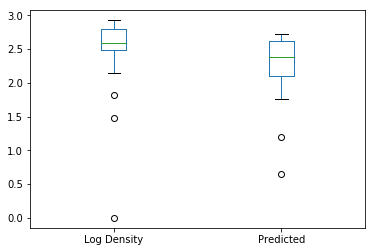

In [35]:
testDf = y_test.to_frame()
testDf['Predicted'] = y_pred_test
testDf.plot(kind='box')
plt.show()

In [36]:
testDf.describe()

,Log Density,Predicted
count,23.000000,23.000000
mean,2.447139,2.248897
std,0.643573,0.513071
min,0.000000,0.657146
25%,2.491588,2.102459
50%,2.591065,2.385715
75%,2.798647,2.623656
max,2.926342,2.726231


Compare scatter plot of actual and predicted for both training and test data to check for overfitting

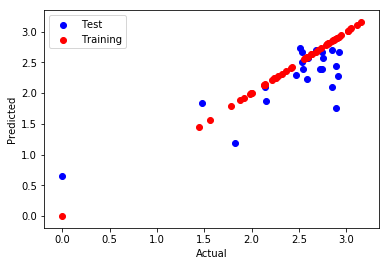

In [37]:
plt.scatter(y_test, y_pred_test, color='blue', label='Test')
plt.scatter(y_train, y_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

Model looks overfitted: it is much more accurate on training dataset than test dataset.
    
Try lasso model instead: it should remove features which are not predictive and reduce the risk of overfitting

The alpha regularisation value of 0.0085 was arrived at by a

In [38]:
lasso = linear_model.Lasso(alpha=0.0085, normalize=True)
lasso.fit(X_train, y_train)
lasso_pred_test = lasso.predict(X_test)
lasso_pred_train = lasso.predict(X_train)
lasso.score(X_test, y_test)

0.5118970006157098

R^2 is still ok

Compare distributions of predicted to actual log density

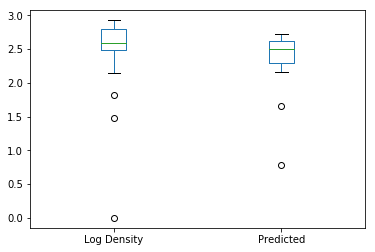

In [39]:
testDf = y_test.to_frame()
testDf['Predicted'] = lasso_pred_test
testDf.plot(kind='box')
plt.show()

Compare scatter plot of actual and predicted for both training and test data to check for overfitting

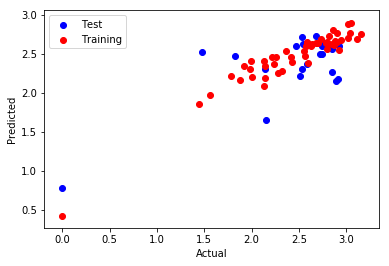

In [40]:
plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend(loc='upper left')
plt.show()

Get all predictions

In [41]:
lasso_pred_all = lasso.predict(X)

Create results dataframe containing Density and Predicted Density for all points in the grid

In [42]:
results = modelData[['Latitude', 'Longitude', 'Density']]
results['Predicted'] = 10 ** lasso_pred_all

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Create dataframe of top 10 locations by difference between predicted and actual density

In [43]:
results['Rank'] = results['Predicted'] - results['Density']
top10 = results.sort_values(by='Rank', ascending=False).head(10)
top10

C:\Users\mattc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,Density,Predicted,Rank
26,43.652163,-79.387207,29.0,333.543761,304.543761
60,43.659363,-79.392165,65.0,297.595192,232.595192
15,43.650363,-79.392165,341.0,516.234263,175.234263
23,43.652163,-79.394645,98.0,257.924652,159.924652
14,43.650363,-79.394645,82.0,223.008651,141.008651
61,43.659363,-79.389686,161.0,293.443853,132.443853
39,43.653963,-79.377290,135.0,257.401395,122.401395
9,43.648563,-79.387207,231.0,344.683099,113.683099
32,43.653963,-79.394645,178.0,289.757553,111.757553
51,43.657563,-79.392165,94.0,204.515079,110.515079


Add top 10 locations to map

In [44]:
l = list(zip(top10['Latitude'], top10['Longitude']))
l

# Add top ranked grid points to map
for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=1,
                        color='Blue').add_to(m)
       
m

Get model coefficients

In [45]:
names = X.columns
lasso_coef = lasso.fit(X_train, y_train).coef_

In [46]:
coeffs = list(zip(names, lasso_coef))
coeffsDf = pd.DataFrame(coeffs)
coeffsDf.columns = ['Category', 'Coefficient']
coeffsRanked = coeffsDf[coeffsDf['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)
coeffsRanked

,Category,Coefficient
186,Mexican Restaurant,0.069153
132,Greek Restaurant,0.043459
205,Office,0.034513
28,Breakfast Spot,0.016775
4,American Restaurant,0.007558
113,Food Court,0.003194
172,Liquor Store,-0.003174
2,Advertising Agency,-0.003614
109,Field,-0.008194
160,Jazz Club,-0.009546


Plot coefficients ranked by predictiveness

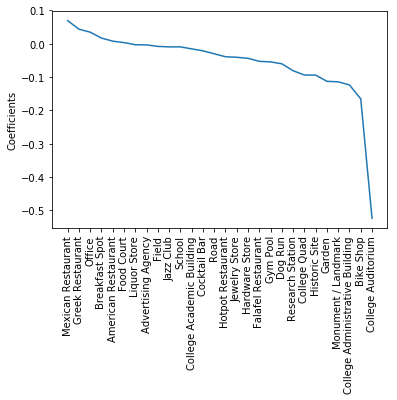

In [47]:
names = coeffsRanked['Category']
_ = plt.plot(range(len(coeffsRanked)), np.transpose(coeffsRanked['Coefficient']).values)
_ = plt.xticks(range(len(coeffsRanked)), names, rotation = 90)
_ = plt.ylabel('Coefficients')
plt.show()

Produce heat map of model predictions

In [48]:
# calculate maximum predicted density to use in heatmap opacity calulation
max_predicted = results['Predicted'].max()

predictions = results[['Latitude', 'Longitude', 'Predicted']].values.tolist()

# Initialise map
m2 = folium.Map(location=[lat, long], zoom_start=14)



# add rectangles around each point in grid to the map
for (lt, lg, prediction) in predictions:
    # use opacity to show scale of prediction
    opacity = prediction / max_predicted
    
    # caluate corners of the rectangle around the current point in grid
    bottomLeft = [lt - tick / ltDeg / 2, lg - tick / lgDeg / 2]
    bottomRight = [lt - tick / ltDeg / 2, lg + tick / lgDeg / 2]
    topRight = [lt + tick / ltDeg / 2, lg + tick / lgDeg / 2]
    topLeft = [lt + tick / ltDeg / 2, lg - tick / lgDeg / 2]
    
    # define the rectangle bounds
    bounds = [bottomLeft, bottomRight, topRight, topLeft]
    
    # add rectangles to map
    folium.features.RectangleMarker(bounds, weight=0, fill_color='red', fill_opacity=float(opacity)).add_to(m2) 

    
# add circle of radius radius around location   
folium.features.Circle((lat, long), radius * 1000, weight = 1, color='black', fill_opacity=0.0).add_to(m2)

# add venues to map
for (v_id, name, vlt, vlg) in targetVenues:
    label = folium.Popup(name, parse_html=True)
    folium.CircleMarker([vlt, vlg],
                        color='black',
                        radius=0.1,
                        popup=label,
                        fill=False).add_to(m2)

# Add top ranked grid points to map
for (lt, lg) in l:
    folium.CircleMarker([lt, lg],
                        radius=2,
                        fill=True,
                        fill_opacity=1,
                        color='Blue').add_to(m2)

# display heatmap
m2

## Appendix: optimizing the alpha setting for Lasso regression
Code below trains models with various alpha settings in order to select the best setting

Alpha = 0.005: R^2 = 0.4973373171417387; Number of features = 38


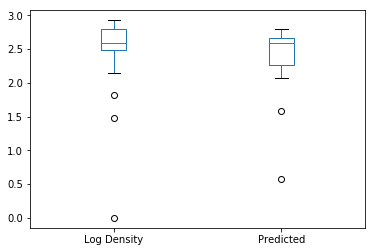

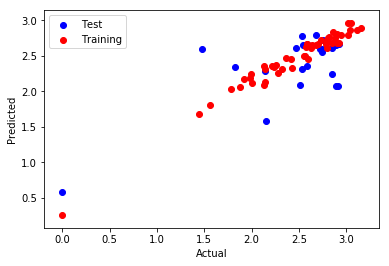

Alpha = 0.006: R^2 = 0.5049036175175556; Number of features = 35


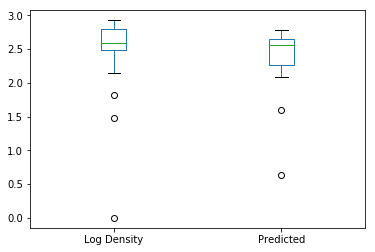

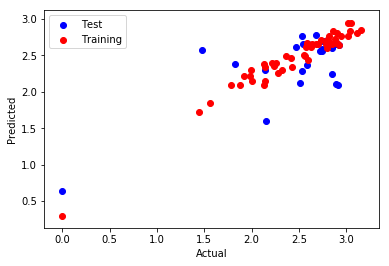

Alpha = 0.007: R^2 = 0.5124494533344832; Number of features = 35


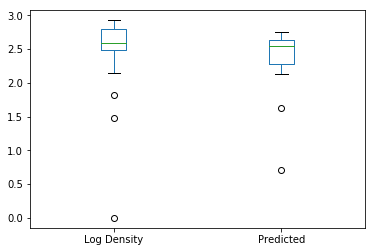

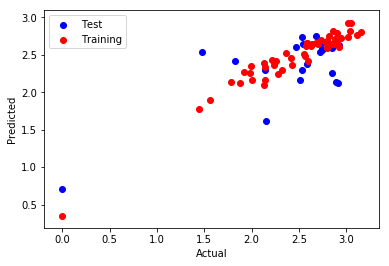

Alpha = 0.008: R^2 = 0.5146146025477186; Number of features = 32


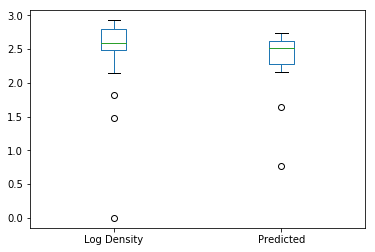

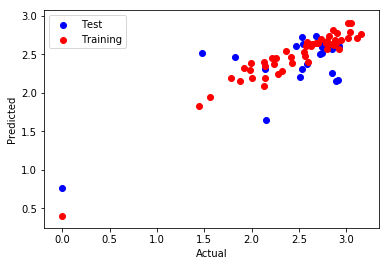

Alpha = 0.009000000000000001: R^2 = 0.5082154178659053; Number of features = 27


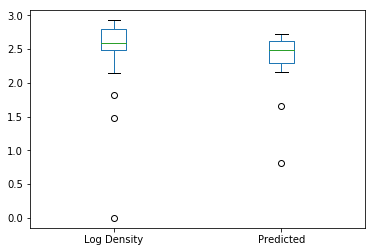

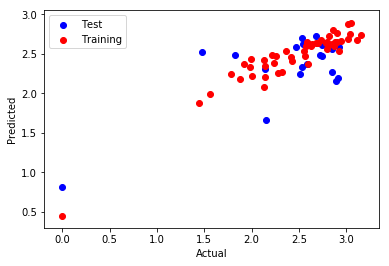

Alpha = 0.01: R^2 = 0.50226570492822; Number of features = 26


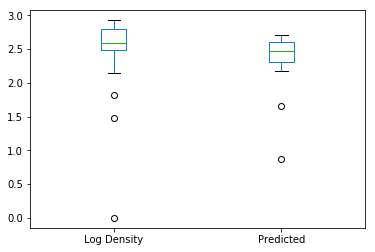

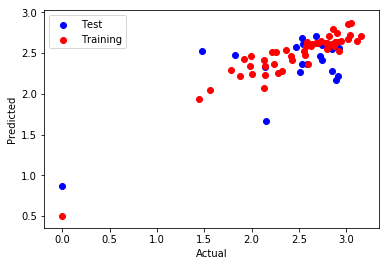

Alpha = 0.011: R^2 = 0.4974389770835207; Number of features = 21


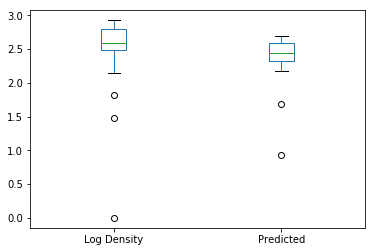

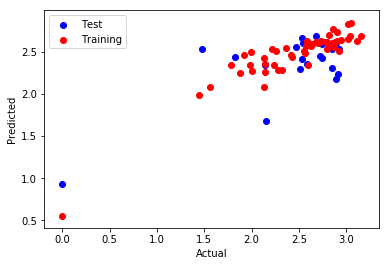

Alpha = 0.012: R^2 = 0.4968469760668808; Number of features = 19


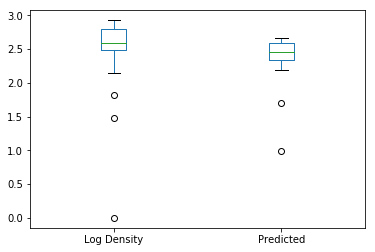

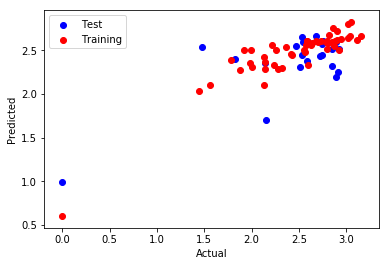

Alpha = 0.013000000000000001: R^2 = 0.4970492312182981; Number of features = 19


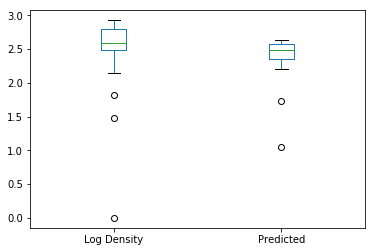

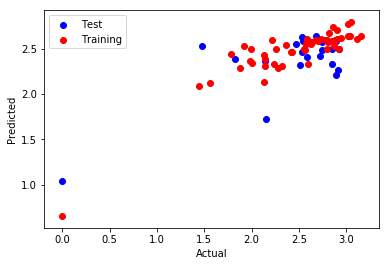

Alpha = 0.014000000000000002: R^2 = 0.49388501205970725; Number of features = 17


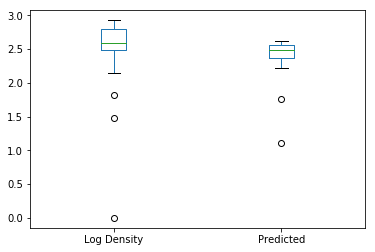

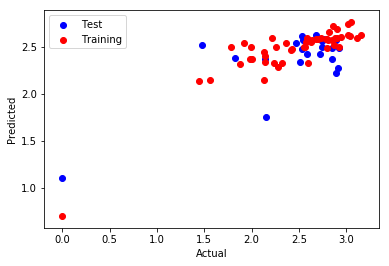

Alpha = 0.015: R^2 = 0.48596450383566236; Number of features = 16


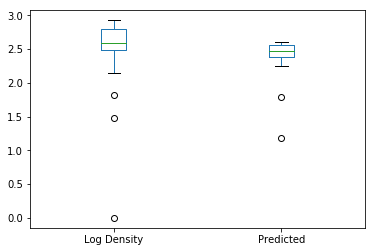

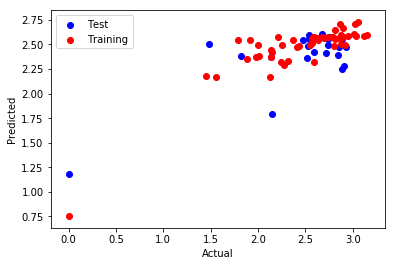

Alpha = 0.016: R^2 = 0.47545030758019297; Number of features = 13


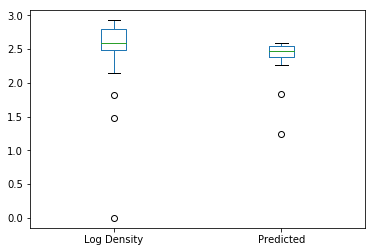

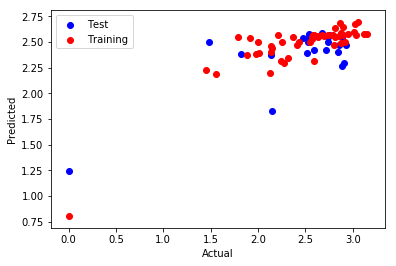

Alpha = 0.017: R^2 = 0.4639292462314081; Number of features = 11


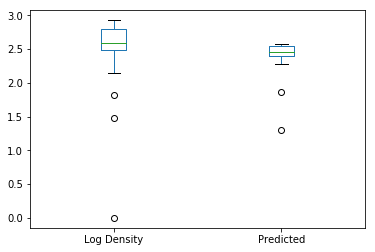

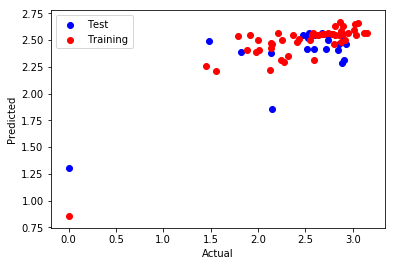

Alpha = 0.018000000000000002: R^2 = 0.4557537295182204; Number of features = 9


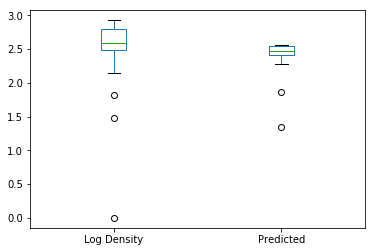

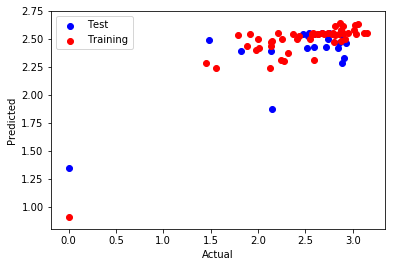

Alpha = 0.019: R^2 = 0.4492163636871437; Number of features = 9


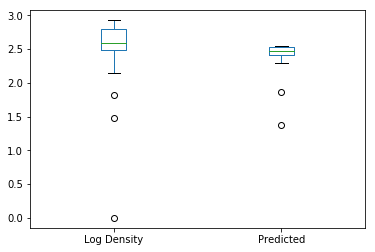

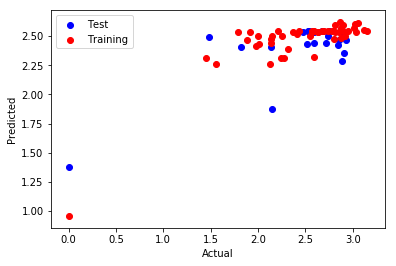

Alpha = 0.02: R^2 = 0.44261646920776965; Number of features = 8


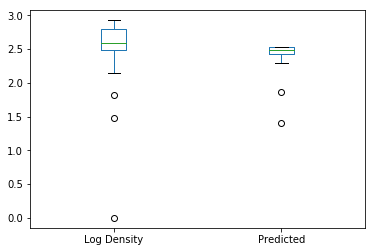

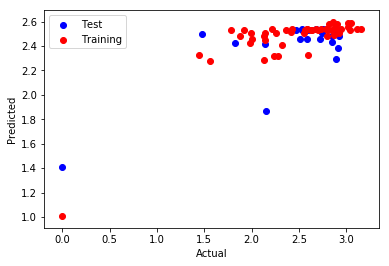

,Alpha,R-Squared,Number of Coefficients
0,0.005,0.497337,38
1,0.006,0.504904,35
2,0.007,0.512449,35
3,0.008,0.514615,32
4,0.009,0.508215,27
5,0.010,0.502266,26
6,0.011,0.497439,21
7,0.012,0.496847,19
8,0.013,0.497049,19
9,0.014,0.493885,17


In [49]:
alphas =np.linspace(0.005,0.02,16)
results = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, normalize=True)
    lasso.fit(X_train, y_train)
    lasso_pred_test = lasso.predict(X_test)
    lasso_pred_train = lasso.predict(X_train)
    rSquared = lasso.score(X_test, y_test)
    
    names = X.columns
    lasso_coef = lasso.coef_
    coeffs = list(zip(names, lasso_coef))
    coeffsDf = pd.DataFrame(coeffs)
    coeffsDf.columns = ['Category', 'Coefficient']
    coeffsRanked = coeffsDf[coeffsDf['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)
    
    names = coeffsRanked['Category']
    
    result = [alpha, rSquared, len(coeffsRanked)]
    results.append(result)
    
    print('Alpha = ' + str(alpha) + ': R^2 = ' + str(rSquared) + '; Number of features = ' + str(len(coeffsRanked)))
    df = y_test.to_frame()
    df['Predicted'] = lasso_pred_test
    df.plot(kind='box')
    plt.show()
    
    plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
    plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend(loc='upper left')
    plt.show()
resultsDf = pd.DataFrame(results)
resultsDf.columns = ['Alpha', 'R-Squared', 'Number of Coefficients']
resultsDf

Alpha = 0.007: R^2 = 0.5124494533344832; Number of features = 35


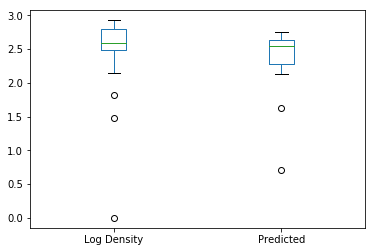

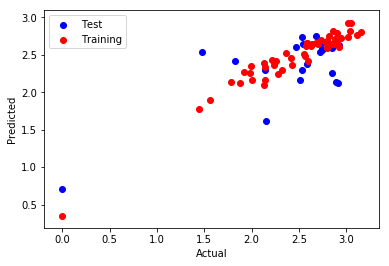

Alpha = 0.0072: R^2 = 0.5132603861927811; Number of features = 34


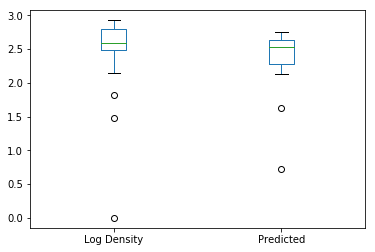

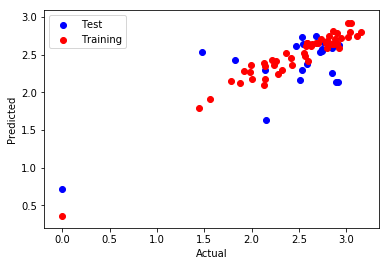

Alpha = 0.0074: R^2 = 0.5139239560773621; Number of features = 32


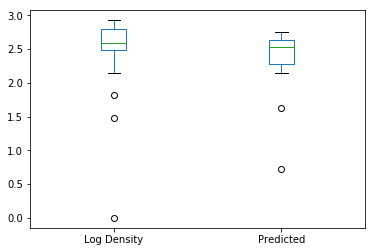

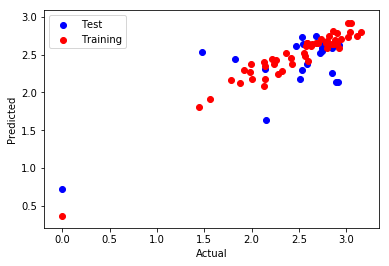

Alpha = 0.0076: R^2 = 0.5142932240983437; Number of features = 32


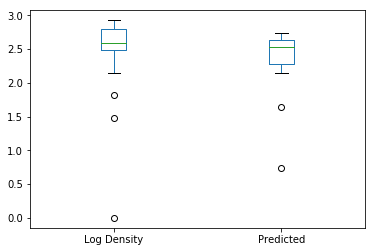

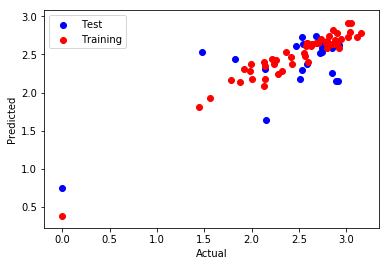

Alpha = 0.0078: R^2 = 0.5144931099530001; Number of features = 32


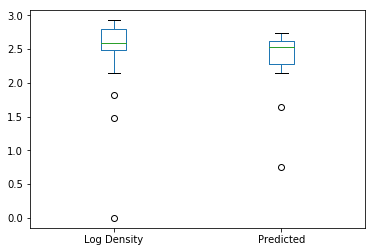

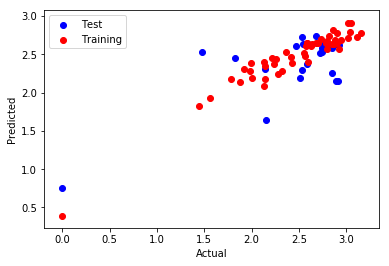

Alpha = 0.008: R^2 = 0.5146146025477186; Number of features = 32


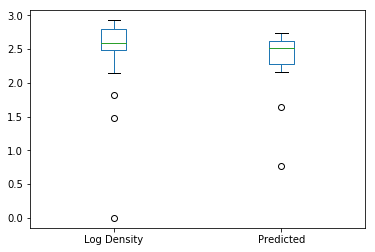

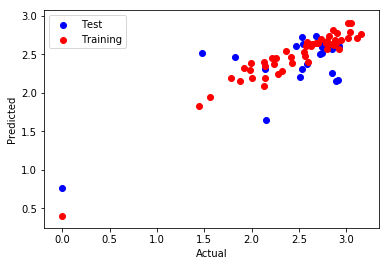

Alpha = 0.008199999999999999: R^2 = 0.5137306565815137; Number of features = 29


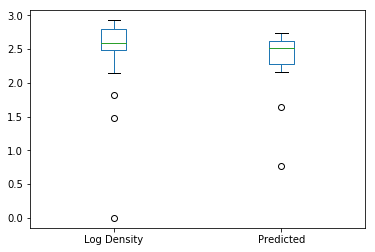

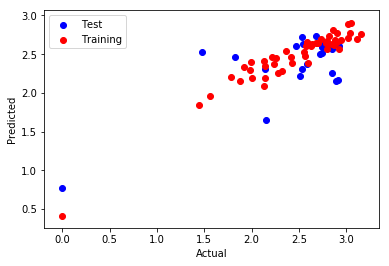

Alpha = 0.0084: R^2 = 0.5125800290639542; Number of features = 28


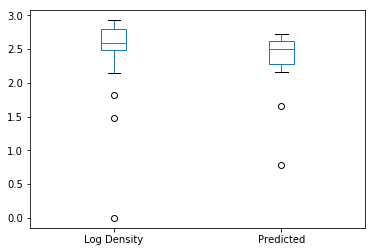

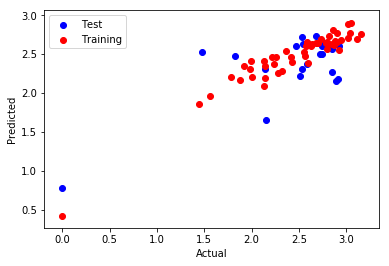

Alpha = 0.0086: R^2 = 0.5111941970878753; Number of features = 28


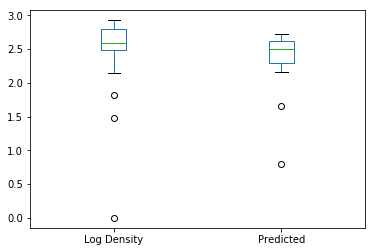

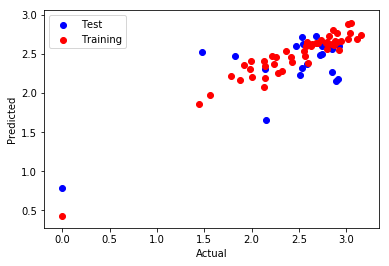

Alpha = 0.008799999999999999: R^2 = 0.5097188880703052; Number of features = 28


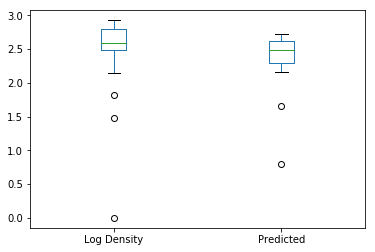

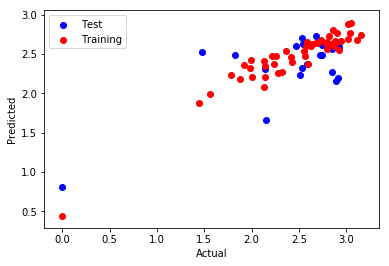

Alpha = 0.009: R^2 = 0.5082154178659053; Number of features = 27


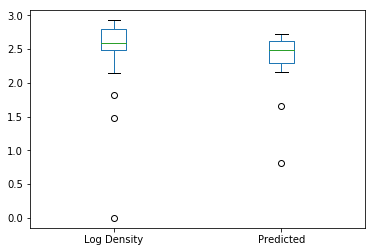

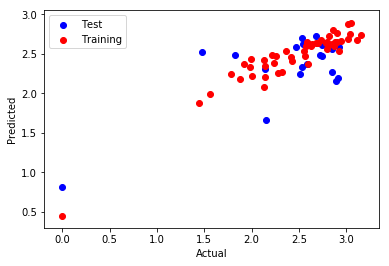

,Alpha,R-Squared,Number of Coefficients
0,0.0070,0.512449,35
1,0.0072,0.513260,34
2,0.0074,0.513924,32
3,0.0076,0.514293,32
4,0.0078,0.514493,32
5,0.0080,0.514615,32
6,0.0082,0.513731,29
7,0.0084,0.512580,28
8,0.0086,0.511194,28
9,0.0088,0.509719,28


In [50]:
alphas = np.linspace(0.007,0.009,11)
results = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, normalize=True)
    lasso.fit(X_train, y_train)
    lasso_pred_test = lasso.predict(X_test)
    lasso_pred_train = lasso.predict(X_train)
    rSquared = lasso.score(X_test, y_test)
    
    names = X.columns
    lasso_coef = lasso.coef_
    coeffs = list(zip(names, lasso_coef))
    coeffsDf = pd.DataFrame(coeffs)
    coeffsDf.columns = ['Category', 'Coefficient']
    coeffsRanked = coeffsDf[coeffsDf['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)
    
    names = coeffsRanked['Category']
    
    result = [alpha, rSquared, len(coeffsRanked)]
    results.append(result)
    
    print('Alpha = ' + str(alpha) + ': R^2 = ' + str(rSquared) + '; Number of features = ' + str(len(coeffsRanked)))
    df = y_test.to_frame()
    df['Predicted'] = lasso_pred_test
    df.plot(kind='box')
    plt.show()
    
    plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
    plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend(loc='upper left')
    plt.show()
resultsDf = pd.DataFrame(results)
resultsDf.columns = ['Alpha', 'R-Squared', 'Number of Coefficients']
resultsDf

Alpha = 0.0082: R^2 = 0.5137306565815141; Number of features = 29


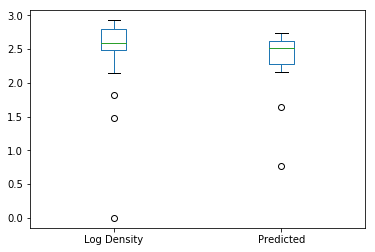

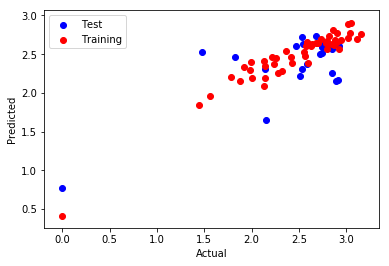

Alpha = 0.0083: R^2 = 0.5132062027711093; Number of features = 29


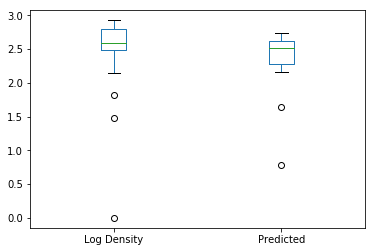

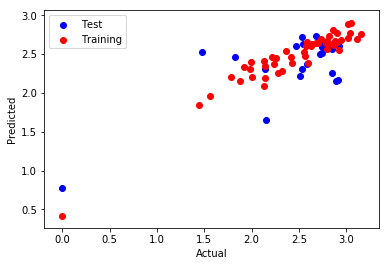

Alpha = 0.008400000000000001: R^2 = 0.5125800290639548; Number of features = 28


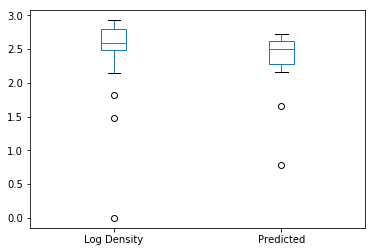

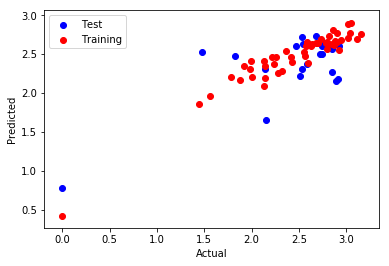

Alpha = 0.0085: R^2 = 0.5118970006157098; Number of features = 28


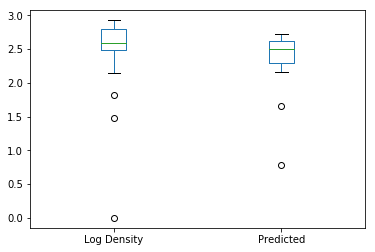

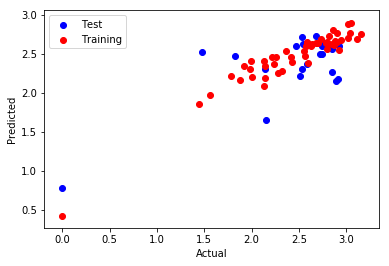

Alpha = 0.0086: R^2 = 0.5111941970878753; Number of features = 28


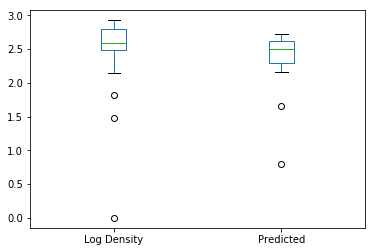

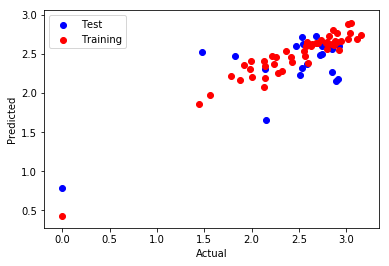

,Alpha,R-Squared,Number of Coefficients
0,0.0082,0.513731,29
1,0.0083,0.513206,29
2,0.0084,0.512580,28
3,0.0085,0.511897,28
4,0.0086,0.511194,28


In [51]:
alphas = np.linspace(0.0082,0.0086,5)
results = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, normalize=True)
    lasso.fit(X_train, y_train)
    lasso_pred_test = lasso.predict(X_test)
    lasso_pred_train = lasso.predict(X_train)
    rSquared = lasso.score(X_test, y_test)
    
    names = X.columns
    lasso_coef = lasso.coef_
    coeffs = list(zip(names, lasso_coef))
    coeffsDf = pd.DataFrame(coeffs)
    coeffsDf.columns = ['Category', 'Coefficient']
    coeffsRanked = coeffsDf[coeffsDf['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)
    
    names = coeffsRanked['Category']
    
    result = [alpha, rSquared, len(coeffsRanked)]
    results.append(result)
    
    print('Alpha = ' + str(alpha) + ': R^2 = ' + str(rSquared) + '; Number of features = ' + str(len(coeffsRanked)))
    df = y_test.to_frame()
    df['Predicted'] = lasso_pred_test
    df.plot(kind='box')
    plt.show()
    
    plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
    plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend(loc='upper left')
    plt.show()
resultsDf = pd.DataFrame(results)
resultsDf.columns = ['Alpha', 'R-Squared', 'Number of Coefficients']
resultsDf

Alpha = 0.0085: R^2 = 0.5118970006157098; Number of features = 28


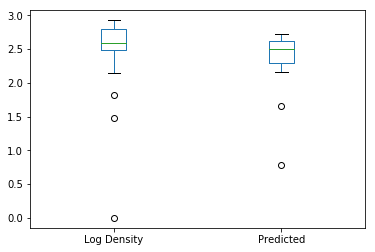

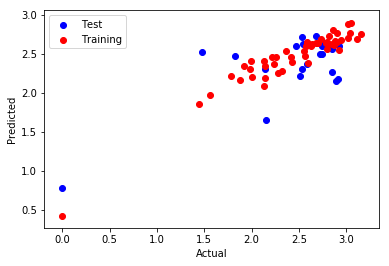

,Alpha,R-Squared,Number of Coefficients
0,0.0085,0.511897,28


In [52]:
alphas = [0.0085]
results = []
for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha, normalize=True)
    lasso.fit(X_train, y_train)
    lasso_pred_test = lasso.predict(X_test)
    lasso_pred_train = lasso.predict(X_train)
    rSquared = lasso.score(X_test, y_test)
    
    names = X.columns
    lasso_coef = lasso.coef_
    coeffs = list(zip(names, lasso_coef))
    coeffsDf = pd.DataFrame(coeffs)
    coeffsDf.columns = ['Category', 'Coefficient']
    coeffsRanked = coeffsDf[coeffsDf['Coefficient'] != 0].sort_values(by='Coefficient', ascending=False)
    
    names = coeffsRanked['Category']
    
    result = [alpha, rSquared, len(coeffsRanked)]
    results.append(result)
    
    print('Alpha = ' + str(alpha) + ': R^2 = ' + str(rSquared) + '; Number of features = ' + str(len(coeffsRanked)))
    df = y_test.to_frame()
    df['Predicted'] = lasso_pred_test
    df.plot(kind='box')
    plt.show()
    
    plt.scatter(y_test, lasso_pred_test, color='blue', label='Test')
    plt.scatter(y_train, lasso_pred_train, color='red', label='Training')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.legend(loc='upper left')
    plt.show()
resultsDf = pd.DataFrame(results)
resultsDf.columns = ['Alpha', 'R-Squared', 'Number of Coefficients']
resultsDf